## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import json

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: preprocessing & feature extraction
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier

# Scikit-learn: models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scikit-learn: evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Load Clean Dataset

In [2]:
# Define paths
DATA_DIR = Path("./data")
MODELS_DIR = Path("./models")
MODELS_DIR.mkdir(exist_ok=True)

INPUT_FILE = DATA_DIR / "english_clean.csv"

print(f"📂 Data directory: {DATA_DIR.resolve()}")
print(f"📂 Models directory: {MODELS_DIR.resolve()}")
print(f"📄 Input file: {INPUT_FILE.name}")

📂 Data directory: C:\Users\Nguyen Ngo\Downloads\NLP PApere\NLP-Trade-Message\data
📂 Models directory: C:\Users\Nguyen Ngo\Downloads\NLP PApere\NLP-Trade-Message\models
📄 Input file: english_clean.csv


In [3]:
# Load dataset
df = pd.read_csv(INPUT_FILE)

print(f"✅ Loaded dataset: {len(df)} records")
print(f"\n📊 Dataset shape: {df.shape}")
print(f"\n🔍 Columns: {df.columns.tolist()}")

# Preview
df.head()

✅ Loaded dataset: 1334 records

📊 Dataset shape: (1334, 9)

🔍 Columns: ['title', 'url', 'root_category', 'subcategory', 'label', 'combined_text', 'clean_text', 'word_count', 'timestamp']


,title,url,root_category,subcategory,label,combined_text,clean_text,word_count,timestamp
0,USA FULLZ + DL + BACKGROUND REPORT MONTANA | N...,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Fraud,SSN/DOB/DL/PII,fraud,USA FULLZ + DL + BACKGROUND REPORT MONTANA | N...,usa fullz dl background report montana nemesis...,23,2023-01-11T13:00:52
1,1 x POWER PLANT XL autoflower seed | Nemesis M...,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Drugs,Cannabis,drug,1 x POWER PLANT XL autoflower seed | Nemesis M...,1 x power plant xl autoflower seed nemesis mar...,189,2023-01-11T13:00:01
2,Ship Marijuana Safely - Instant Delivery | Nem...,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Other,Guides and Tutorials,guide,Ship Marijuana Safely - Instant Delivery | Nem...,ship marijuana safely instant delivery nemesis...,142,2023-01-11T12:59:34
3,1x Feminized AUTOFLOWER AK-47 Cannabis Seeds |...,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Drugs,Cannabis,drug,1x Feminized AUTOFLOWER AK-47 Cannabis Seeds |...,1x feminized autoflower ak 47 cannabis seeds n...,178,2023-01-11T12:59:08
4,1 x KALASHNIKOV autoflower seed | Nemesis Market,http://nemesis555nchzn2dogee6mlc7xxgeeshqirmh3...,Drugs,Cannabis,drug,1 x KALASHNIKOV autoflower seed | Nemesis Mark...,1 x kalashnikov autoflower seed nemesis market...,170,2023-01-11T12:58:53


In [4]:
# Check for missing values in critical columns
critical_cols = ['clean_text', 'label']

print("🔍 Checking missing values in critical columns:")
for col in critical_cols:
    missing = df[col].isnull().sum()
    print(f"   {col}: {missing} ({missing/len(df)*100:.2f}%)")

# Remove rows with missing text or label
before = len(df)
df = df.dropna(subset=critical_cols)
after = len(df)

if before > after:
    print(f"\n🚫 Removed {before - after} rows with missing critical data")
else:
    print("\n✅ No missing values in critical columns")

print(f"\n📊 Final dataset size: {len(df)} records")

🔍 Checking missing values in critical columns:
   clean_text: 0 (0.00%)
   label: 0 (0.00%)

✅ No missing values in critical columns

📊 Final dataset size: 1334 records


## 3. Exploratory Data Analysis

🏷️  LABEL DISTRIBUTION:

label
drug       607
fraud      452
guide      134
other       96
hacking     45
Name: count, dtype: int64

Percentages:
label
drug       45.50
fraud      33.88
guide      10.04
other       7.20
hacking     3.37
Name: count, dtype: float64


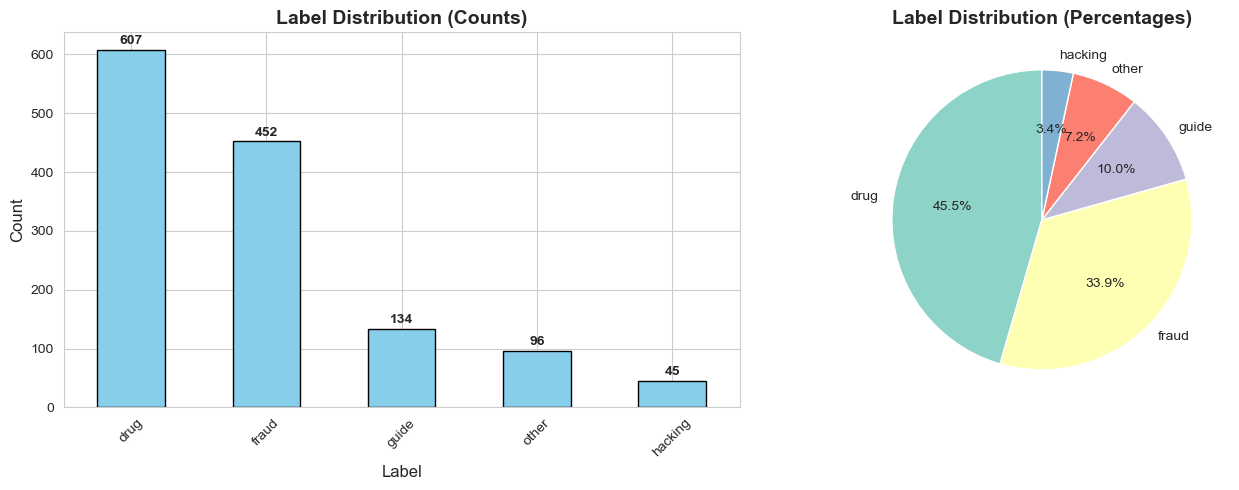

In [5]:
# Label distribution
print("🏷️  LABEL DISTRIBUTION:\n")
label_counts = df['label'].value_counts()
print(label_counts)
print(f"\nPercentages:")
print((label_counts / len(df) * 100).round(2))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
label_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_xlabel('Label', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Label Distribution (Counts)', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
# Add count labels
for i, v in enumerate(label_counts.values):
    ax1.text(i, v + 10, str(v), ha='center', fontweight='bold')

# Pie chart
colors = plt.cm.Set3(range(len(label_counts)))
ax2.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax2.set_title('Label Distribution (Percentages)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

📏 TEXT LENGTH STATISTICS BY LABEL:

fraud          : avg=  97.6 words, median=   96 words
drug           : avg= 109.9 words, median=  113 words
guide          : avg= 107.8 words, median=  100 words
hacking        : avg=  95.9 words, median=   88 words
other          : avg= 126.1 words, median=  124 words


<Figure size 1200x600 with 0 Axes>

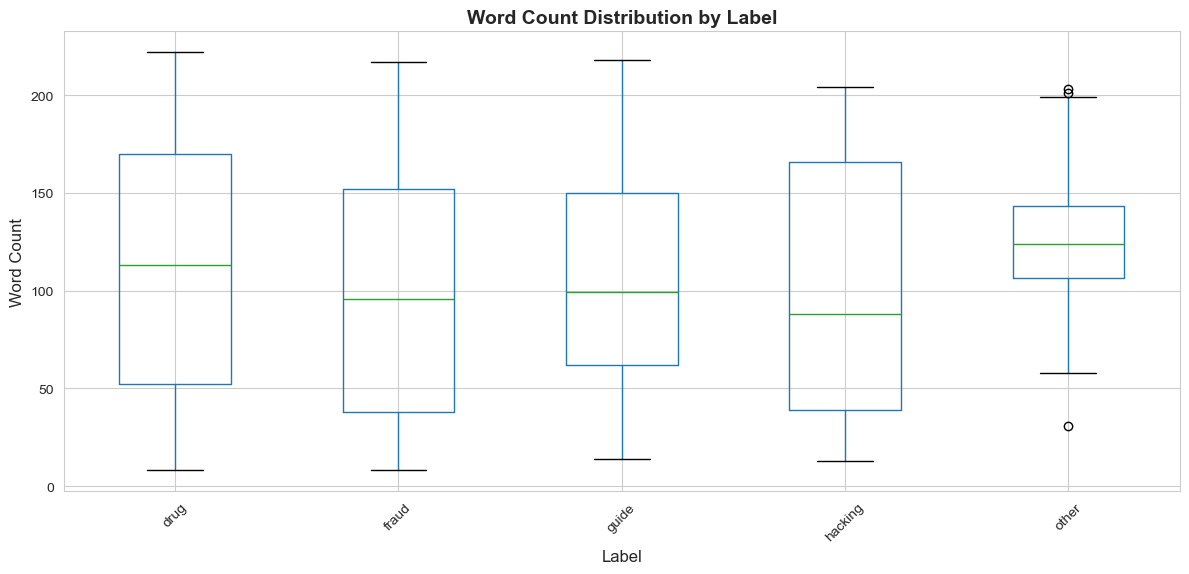

In [6]:
# Text length statistics by label
print("📏 TEXT LENGTH STATISTICS BY LABEL:\n")

for label in df['label'].unique():
    subset = df[df['label'] == label]
    avg_len = subset['word_count'].mean()
    median_len = subset['word_count'].median()
    print(f"{label:15s}: avg={avg_len:6.1f} words, median={median_len:5.0f} words")

# Box plot
plt.figure(figsize=(12, 6))
df.boxplot(column='word_count', by='label', figsize=(12, 6))
plt.suptitle('')
plt.title('Word Count Distribution by Label', fontsize=14, fontweight='bold')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Sample texts from each label
print("📋 SAMPLE TEXTS FROM EACH LABEL:\n")

for label in sorted(df['label'].unique()):
    print(f"\n{'='*70}")
    print(f"Label: {label.upper()}")
    print(f"{'='*70}")
    samples = df[df['label'] == label].sample(min(2, len(df[df['label'] == label])), random_state=42)
    for i, (title, text) in enumerate(zip(samples['title'], samples['clean_text']), 1):
        print(f"\n{i}. Title: {title}")
        print(f"   Text preview: {text[:200]}...")

📋 SAMPLE TEXTS FROM EACH LABEL:


Label: DRUG

1. Title: 125g Of Mimosa Cannabis Dust - AUSTRALIAN IMPORT FREE NDD | Nemesis Market
   Text preview: 125g of mimosa cannabis dust australian import free ndd nemesis market. hybrid marijuana, from australia.. feel happy, relaxed and motivational reduce depression and stress.. order now and recieve tom...

2. Title: BEST KETAMINE/KET/KETAMIN PURE INDIAN S-ISOMER LONG SHARDS 28G ***FREE UK DELIVERY*** | Nemesis Mark
   Text preview: best ketamine ket ketamin pure indian s isomer long shards 28g free uk delivery nemesis mark. we have some pharma grade ketamine for sale, the product is exactly as shown in the picture, we have locat...

Label: FRAUD

1. Title: Frontside Drivers License | Nemesis Market
   Text preview: frontside drivers license nemesis market. whats included i will make any front side copy of any states drivers license. with the exception of washington dc these can pass nearly any site verification....

2. Title: Kansas Driver 

## 4. Train/Validation/Test Split

**Strategy:**
- Train: 70%
- Validation: 15%
- Test: 15%
- Stratified split to maintain label distribution

In [8]:
# Prepare features and labels
X = df['clean_text'].values
y = df['label'].values

print(f"📊 Total samples: {len(X)}")
print(f"🏷️  Unique labels: {np.unique(y)}")
print(f"\n📈 Label distribution:")
for label in np.unique(y):
    count = (y == label).sum()
    print(f"   {label:15s}: {count:4d} ({count/len(y)*100:5.2f}%)")

📊 Total samples: 1334
🏷️  Unique labels: ['drug' 'fraud' 'guide' 'hacking' 'other']

📈 Label distribution:
   drug           :  607 (45.50%)
   fraud          :  452 (33.88%)
   guide          :  134 (10.04%)
   hacking        :   45 ( 3.37%)
   other          :   96 ( 7.20%)


In [9]:
# First split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=RANDOM_STATE, 
    stratify=y
)

# Second split: validation (15%) and test (15%) from temp (30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=RANDOM_STATE, 
    stratify=y_temp
)

print("✅ Data split complete!")
print(f"\n📊 Split sizes:")
print(f"   Train:      {len(X_train):4d} ({len(X_train)/len(X)*100:5.2f}%)")
print(f"   Validation: {len(X_val):4d} ({len(X_val)/len(X)*100:5.2f}%)")
print(f"   Test:       {len(X_test):4d} ({len(X_test)/len(X)*100:5.2f}%)")

✅ Data split complete!

📊 Split sizes:
   Train:       933 (69.94%)
   Validation:  200 (14.99%)
   Test:        201 (15.07%)


In [10]:
# Verify stratification
print("🔍 Verifying stratified split:\n")

print("Label distribution across splits:")
print(f"\n{'Label':15s} {'Original':>10s} {'Train':>10s} {'Val':>10s} {'Test':>10s}")
print("-" * 65)

for label in np.unique(y):
    orig_pct = (y == label).sum() / len(y) * 100
    train_pct = (y_train == label).sum() / len(y_train) * 100
    val_pct = (y_val == label).sum() / len(y_val) * 100
    test_pct = (y_test == label).sum() / len(y_test) * 100
    
    print(f"{label:15s} {orig_pct:9.2f}% {train_pct:9.2f}% {val_pct:9.2f}% {test_pct:9.2f}%")

print("\n✅ Stratification maintained across all splits!")

🔍 Verifying stratified split:

Label distribution across splits:

Label             Original      Train        Val       Test
-----------------------------------------------------------------
drug                45.50%     45.55%     45.50%     45.27%
fraud               33.88%     33.87%     34.00%     33.83%
guide               10.04%     10.08%     10.00%      9.95%
hacking              3.37%      3.32%      3.50%      3.48%
other                7.20%      7.18%      7.00%      7.46%

✅ Stratification maintained across all splits!


## 5. TF-IDF Feature Extraction

**Configuration:**
- N-grams: (1, 2) - unigrams and bigrams
- Max features: 10,000
- Min document frequency: 2
- Max document frequency: 0.95 (remove very common terms)
- Sublinear TF: True (use 1 + log(tf) instead of raw tf)

In [11]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),      # unigrams + bigrams
    max_features=10000,      # limit vocabulary size
    min_df=2,                # ignore terms appearing in less than 2 documents
    max_df=0.95,             # ignore terms appearing in more than 95% of documents
    sublinear_tf=True,       # use log scaling for term frequency
    strip_accents='unicode',
    lowercase=True,
    stop_words='english'     # remove common English stopwords
)

print("🔧 TF-IDF Vectorizer Configuration:")
print(f"   N-gram range: {tfidf.ngram_range}")
print(f"   Max features: {tfidf.max_features}")
print(f"   Min DF: {tfidf.min_df}")
print(f"   Max DF: {tfidf.max_df}")
print(f"   Sublinear TF: {tfidf.sublinear_tf}")
print(f"   Stop words: {tfidf.stop_words}")

🔧 TF-IDF Vectorizer Configuration:
   N-gram range: (1, 2)
   Max features: 10000
   Min DF: 2
   Max DF: 0.95
   Sublinear TF: True
   Stop words: english


In [12]:
# Fit on training data and transform all splits
print("🔄 Fitting TF-IDF vectorizer on training data...")
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print("\n✅ TF-IDF transformation complete!")
print(f"\n📊 Feature matrix shapes:")
print(f"   Train:      {X_train_tfidf.shape}")
print(f"   Validation: {X_val_tfidf.shape}")
print(f"   Test:       {X_test_tfidf.shape}")
print(f"\n📝 Vocabulary size: {len(tfidf.vocabulary_):,} terms")
print(f"💾 Matrix sparsity: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")

🔄 Fitting TF-IDF vectorizer on training data...

✅ TF-IDF transformation complete!

📊 Feature matrix shapes:
   Train:      (933, 10000)
   Validation: (200, 10000)
   Test:       (201, 10000)

📝 Vocabulary size: 10,000 terms
💾 Matrix sparsity: 99.25%


In [13]:
# Inspect top features
feature_names = tfidf.get_feature_names_out()

print("🔍 Sample features (first 50):")
print(feature_names[:50])

print("\n🔍 Sample bigrams (from position 5000-5020):")
bigrams = [f for f in feature_names if ' ' in f]
print(bigrams[:20] if bigrams else "No bigrams found")

🔍 Sample features (first 50):
['00' '00 dutch' '000' '000 ongoing' '000 worldwide' '002' '01' '01 2022'
 '02' '02 alternative' '04' '04 01' '05' '06' '07' '09' '09 22' '10'
 '10 000' '10 10' '10 15' '10 20' '10 21' '10 25' '10 30' '10 500'
 '10 active' '10 blisters' '10 business' '10 days' '10 isbn' '10 mg'
 '10 ml' '10 months' '10 nemesis' '10 new' '10 peaces' '10 pills'
 '10 super' '10 weeks' '100' '100 000' '100 200' '100 250' '100 300'
 '100 capsules' '100 don' '100 engraved' '100 fresh' '100 grams']

🔍 Sample bigrams (from position 5000-5020):
['00 dutch', '000 ongoing', '000 worldwide', '01 2022', '02 alternative', '04 01', '09 22', '10 000', '10 10', '10 15', '10 20', '10 21', '10 25', '10 30', '10 500', '10 active', '10 blisters', '10 business', '10 days', '10 isbn']


## 6. Baseline Model Training

We will train 5 baseline models:
1. **Logistic Regression** - Strong linear baseline
2. **Linear SVM (LinearSVC)** - Fast and effective for text
3. **Multinomial Naive Bayes** - Classic text classification
4. **Random Forest** - Ensemble tree-based method
5. **Gradient Boosting** - Advanced boosting technique

In [14]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        C=1.0,
        solver='lbfgs',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'Linear SVM': LinearSVC(
        C=1.0,
        max_iter=1000,
        random_state=RANDOM_STATE
    ),
    'Multinomial NB': MultinomialNB(
        alpha=1.0
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=RANDOM_STATE
    )
}

print("🤖 Models to train:")
for i, name in enumerate(models.keys(), 1):
    print(f"   {i}. {name}")

🤖 Models to train:
   1. Logistic Regression
   2. Linear SVM
   3. Multinomial NB
   4. Random Forest
   5. Gradient Boosting


In [15]:
# Train all models
trained_models = {}
training_times = {}

import time

print("🚀 Training models...\n")

for name, model in models.items():
    print(f"Training {name}...", end=' ')
    start_time = time.time()
    
    model.fit(X_train_tfidf, y_train)
    
    elapsed = time.time() - start_time
    training_times[name] = elapsed
    trained_models[name] = model
    
    print(f"✅ Done in {elapsed:.2f}s")

print("\n✅ All models trained successfully!")

🚀 Training models...

Training Logistic Regression... ✅ Done in 3.15s
Training Linear SVM... ✅ Done in 0.03s
Training Multinomial NB... ✅ Done in 0.01s
Training Random Forest... ✅ Done in 0.21s
Training Gradient Boosting... ✅ Done in 20.62s

✅ All models trained successfully!


## 7. Model Evaluation & Comparison

In [16]:
# Evaluate all models on validation set
results = []

print("📊 Evaluating models on validation set...\n")

for name, model in trained_models.items():
    # Predictions
    y_pred = model.predict(X_val_tfidf)
    
    # Calculate metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Training Time (s)': training_times[name]
    })
    
    print(f"{name:20s} - Acc: {acc:.4f}, F1: {f1:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print("📊 VALIDATION SET RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

📊 Evaluating models on validation set...

Logistic Regression  - Acc: 0.8650, F1: 0.7383
Linear SVM           - Acc: 0.8850, F1: 0.7511
Multinomial NB       - Acc: 0.8600, F1: 0.6158
Random Forest        - Acc: 0.8350, F1: 0.7302
Gradient Boosting    - Acc: 0.8500, F1: 0.7396

📊 VALIDATION SET RESULTS
              Model  Accuracy  Precision  Recall  F1-Score  Training Time (s)
         Linear SVM     0.885     0.8407  0.7139    0.7511             0.0303
  Gradient Boosting     0.850     0.8573  0.6933    0.7396            20.6172
Logistic Regression     0.865     0.9016  0.6724    0.7383             3.1453
      Random Forest     0.835     0.8788  0.6703    0.7302             0.2085
     Multinomial NB     0.860     0.6920  0.5968    0.6158             0.0061


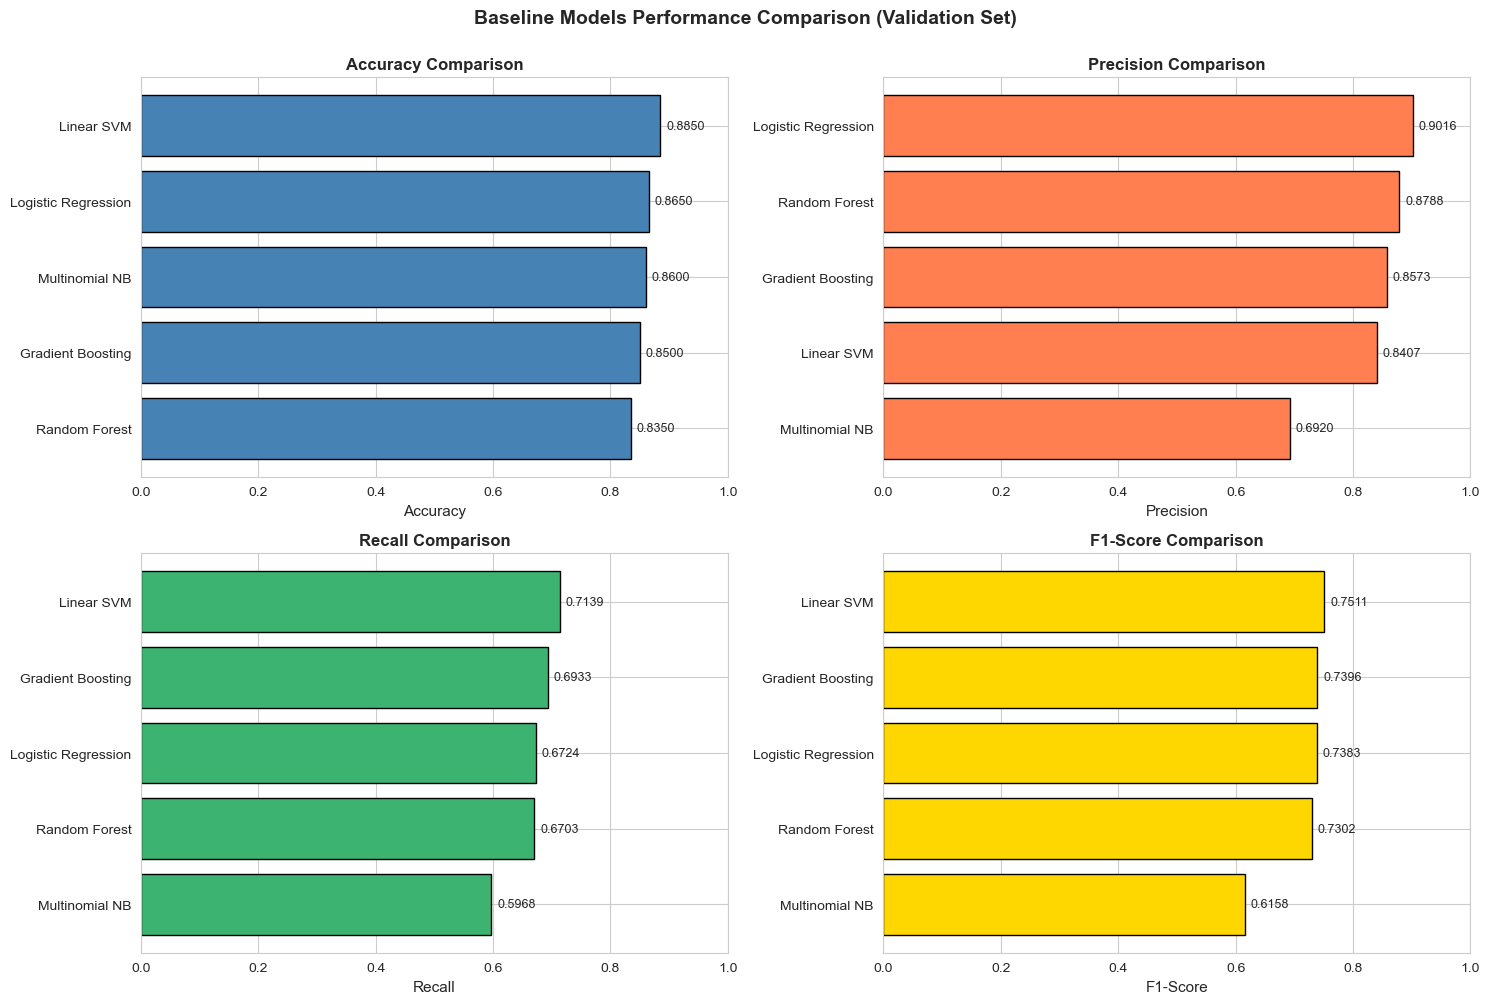

In [17]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['steelblue', 'coral', 'mediumseagreen', 'gold']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    
    sorted_df = results_df.sort_values(metric, ascending=True)
    
    ax.barh(sorted_df['Model'], sorted_df[metric], color=color, edgecolor='black')
    ax.set_xlabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xlim([0, 1.0])
    
    # Add value labels
    for i, v in enumerate(sorted_df[metric]):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9)

plt.suptitle('Baseline Models Performance Comparison (Validation Set)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [18]:
# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")
print(f"   Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")


🏆 BEST MODEL: Linear SVM
   F1-Score: 0.7511
   Accuracy: 0.8850


### 7.1 Train Ensemble Voting Classifier

Combine best performing models for improved accuracy.

In [19]:
# Create ensemble voting classifier with top 3 models
top_3_models = results_df.head(3)['Model'].tolist()

print(f"🎯 Creating ensemble from top 3 models:")
for i, model_name in enumerate(top_3_models, 1):
    f1 = results_df[results_df['Model'] == model_name].iloc[0]['F1-Score']
    print(f"   {i}. {model_name:20s} (F1: {f1:.4f})")

# Create voting classifier
# Note: LinearSVC doesn't support predict_proba, so we'll use 'hard' voting
ensemble_estimators = [(name, trained_models[name]) for name in top_3_models]

# Check if any model doesn't support predict_proba
has_linear_svc = any('Linear SVM' in name for name in top_3_models)
voting_type = 'hard' if has_linear_svc else 'soft'

voting_clf = VotingClassifier(
    estimators=ensemble_estimators,
    voting=voting_type,  # use hard voting if LinearSVC is present
    n_jobs=-1
)

print(f"\n🔧 Using '{voting_type}' voting (LinearSVC detected)" if has_linear_svc else f"\n🔧 Using '{voting_type}' voting")
print("🔄 Training ensemble classifier...")
import time
start_time = time.time()
voting_clf.fit(X_train_tfidf, y_train)
elapsed = time.time() - start_time
print(f"✅ Ensemble trained in {elapsed:.2f}s")

# Evaluate ensemble
y_pred_ensemble = voting_clf.predict(X_val_tfidf)

acc_ensemble = accuracy_score(y_val, y_pred_ensemble)
prec_ensemble = precision_score(y_val, y_pred_ensemble, average='macro', zero_division=0)
rec_ensemble = recall_score(y_val, y_pred_ensemble, average='macro', zero_division=0)
f1_ensemble = f1_score(y_val, y_pred_ensemble, average='macro', zero_division=0)

print(f"\n📊 Ensemble Voting Classifier Performance:")
print(f"   Accuracy:  {acc_ensemble:.4f}")
print(f"   Precision: {prec_ensemble:.4f}")
print(f"   Recall:    {rec_ensemble:.4f}")
print(f"   F1-Score:  {f1_ensemble:.4f}")

# Add ensemble to results
ensemble_result = {
    'Model': 'Ensemble (Voting)',
    'Accuracy': acc_ensemble,
    'Precision': prec_ensemble,
    'Recall': rec_ensemble,
    'F1-Score': f1_ensemble,
    'Training Time (s)': elapsed
}

results_df = pd.concat([results_df, pd.DataFrame([ensemble_result])], ignore_index=True)
results_df = results_df.sort_values('F1-Score', ascending=False)

print(f"\n🎉 Improvement over best single model:")
best_single_f1 = results_df[results_df['Model'] != 'Ensemble (Voting)'].iloc[0]['F1-Score']
improvement = ((f1_ensemble - best_single_f1) / best_single_f1) * 100
print(f"   F1-Score improvement: {improvement:+.2f}%")

# Update best model if ensemble is better
if f1_ensemble > best_single_f1:
    best_model_name = 'Ensemble (Voting)'
    best_model = voting_clf
    trained_models[best_model_name] = voting_clf
    training_times[best_model_name] = elapsed
    print(f"\n🏆 NEW BEST MODEL: {best_model_name}")

🎯 Creating ensemble from top 3 models:
   1. Linear SVM           (F1: 0.7511)
   2. Gradient Boosting    (F1: 0.7396)
   3. Logistic Regression  (F1: 0.7383)

🔧 Using 'hard' voting (LinearSVC detected)
🔄 Training ensemble classifier...
✅ Ensemble trained in 24.03s

📊 Ensemble Voting Classifier Performance:
   Accuracy:  0.8800
   Precision: 0.9034
   Recall:    0.7109
   F1-Score:  0.7667

🎉 Improvement over best single model:
   F1-Score improvement: +2.08%

🏆 NEW BEST MODEL: Ensemble (Voting)


### 7.2 Cross-Validation for Best Models

Perform k-fold cross-validation to ensure robust performance.

🔄 Performing 5-fold stratified cross-validation...

Linear SVM           - F1: 0.7861 (±0.0188)
Gradient Boosting    - F1: 0.7878 (±0.0352)
Logistic Regression  - F1: 0.7014 (±0.0393)
Ensemble (Voting)    - F1: 0.7697 (±0.0114)

📊 CROSS-VALIDATION RESULTS (5-Fold)
              Model  CV F1 Mean  CV F1 Std  CV F1 Min  CV F1 Max
  Gradient Boosting      0.7878     0.0352     0.7650     0.8573
         Linear SVM      0.7861     0.0188     0.7615     0.8153
  Ensemble (Voting)      0.7697     0.0114     0.7567     0.7868
Logistic Regression      0.7014     0.0393     0.6241     0.7336


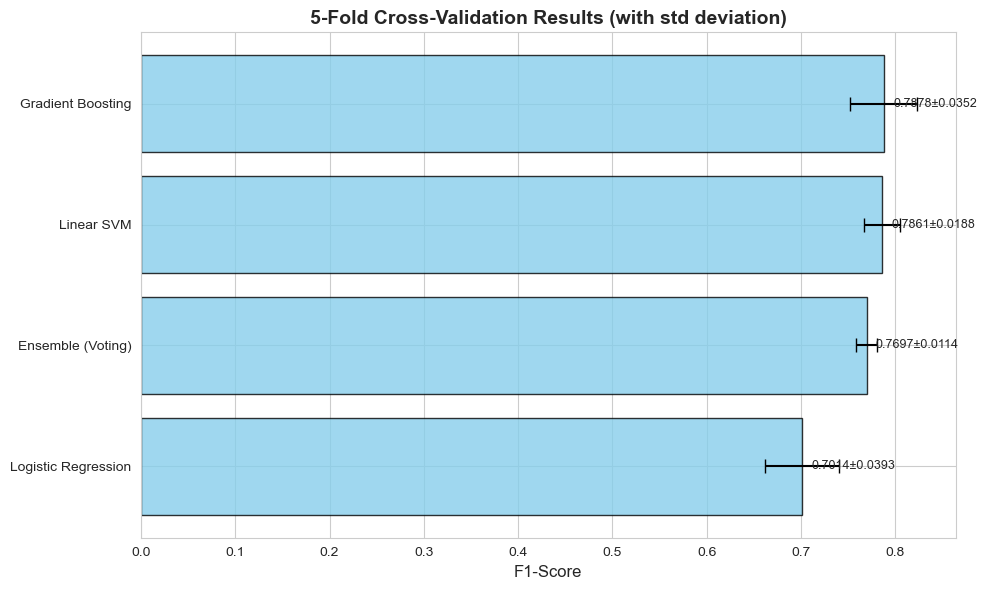

In [20]:
# Perform 5-fold cross-validation on top 3 models + ensemble
print("🔄 Performing 5-fold stratified cross-validation...\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Combine train and validation for CV
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
X_train_val_tfidf = tfidf.fit_transform(X_train_val)

cv_results = []

for model_name in top_3_models + ['Ensemble (Voting)']:
    model = trained_models[model_name]
    
    # Perform cross-validation
    scores = cross_val_score(
        model, X_train_val_tfidf, y_train_val, 
        cv=cv, scoring='f1_macro', n_jobs=-1
    )
    
    cv_results.append({
        'Model': model_name,
        'CV F1 Mean': scores.mean(),
        'CV F1 Std': scores.std(),
        'CV F1 Min': scores.min(),
        'CV F1 Max': scores.max()
    })
    
    print(f"{model_name:20s} - F1: {scores.mean():.4f} (±{scores.std():.4f})")

cv_results_df = pd.DataFrame(cv_results)
cv_results_df = cv_results_df.sort_values('CV F1 Mean', ascending=False)

print("\n" + "="*80)
print("📊 CROSS-VALIDATION RESULTS (5-Fold)")
print("="*80)
print(cv_results_df.to_string(index=False))
print("="*80)

# Visualize CV results
fig, ax = plt.subplots(figsize=(10, 6))

models_cv = cv_results_df['Model'].values
means = cv_results_df['CV F1 Mean'].values
stds = cv_results_df['CV F1 Std'].values

x_pos = np.arange(len(models_cv))
ax.barh(x_pos, means, xerr=stds, capsize=5, color='skyblue', edgecolor='black', alpha=0.8)
ax.set_yticks(x_pos)
ax.set_yticklabels(models_cv)
ax.set_xlabel('F1-Score', fontsize=12)
ax.set_title('5-Fold Cross-Validation Results (with std deviation)', fontsize=14, fontweight='bold')
ax.invert_yaxis()

for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(mean + 0.01, i, f'{mean:.4f}±{std:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [21]:
# Detailed classification report for best model
y_pred_best = best_model.predict(X_val_tfidf)

print(f"\n{'='*80}")
print(f"CLASSIFICATION REPORT - {best_model_name} (Validation Set)")
print(f"{'='*80}\n")
print(classification_report(y_val, y_pred_best, digits=4))


CLASSIFICATION REPORT - Ensemble (Voting) (Validation Set)

              precision    recall  f1-score   support

        drug     0.9100    1.0000    0.9529        91
       fraud     0.8378    0.9118    0.8732        68
       guide     1.0000    0.5000    0.6667        20
     hacking     1.0000    0.4286    0.6000         7
       other     0.7692    0.7143    0.7407        14

    accuracy                         0.8800       200
   macro avg     0.9034    0.7109    0.7667       200
weighted avg     0.8878    0.8800    0.8700       200



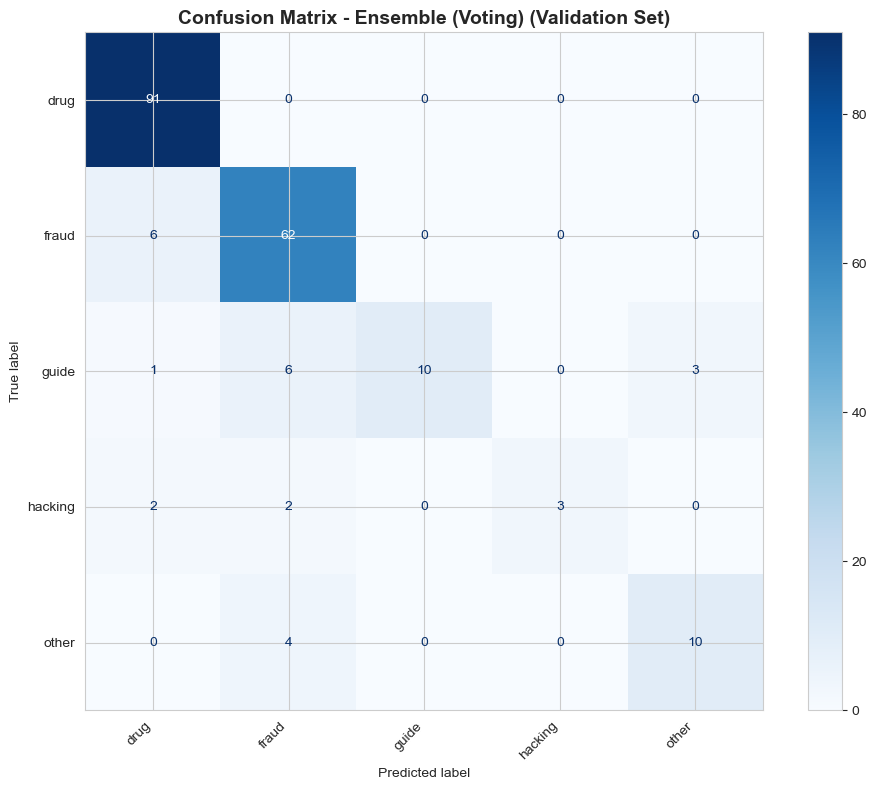


📊 Per-class accuracy:
   drug           : 1.0000 (91/91)
   fraud          : 0.9118 (62/68)
   guide          : 0.5000 (10/20)
   hacking        : 0.4286 (3/7)
   other          : 0.7143 (10/14)


In [22]:
# Confusion matrix for best model
cm = confusion_matrix(y_val, y_pred_best)
labels = sorted(np.unique(y_val))

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title(f'Confusion Matrix - {best_model_name} (Validation Set)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\n📊 Per-class accuracy:")
for i, label in enumerate(labels):
    class_acc = cm[i, i] / cm[i].sum()
    print(f"   {label:15s}: {class_acc:.4f} ({cm[i, i]}/{cm[i].sum()})")

In [23]:
# Evaluate ALL models on test set
print("\n" + "="*80)
print("📊 FINAL EVALUATION ON TEST SET")
print("="*80 + "\n")

test_results = []

for name, model in trained_models.items():
    y_pred_test = model.predict(X_test_tfidf)
    
    acc = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred_test, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred_test, average='macro', zero_division=0)
    
    test_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    print(f"{name:20s} - Acc: {acc:.4f}, F1: {f1:.4f}")

test_results_df = pd.DataFrame(test_results)
test_results_df = test_results_df.sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print(test_results_df.to_string(index=False))
print("="*80)


📊 FINAL EVALUATION ON TEST SET

Logistic Regression  - Acc: 0.8458, F1: 0.6469
Linear SVM           - Acc: 0.8756, F1: 0.7141
Multinomial NB       - Acc: 0.8507, F1: 0.5919
Random Forest        - Acc: 0.7861, F1: 0.6035
Gradient Boosting    - Acc: 0.8159, F1: 0.6383
Ensemble (Voting)    - Acc: 0.8557, F1: 0.6636

              Model  Accuracy  Precision  Recall  F1-Score
         Linear SVM    0.8756     0.7679  0.6828    0.7141
  Ensemble (Voting)    0.8557     0.7608  0.6280    0.6636
Logistic Regression    0.8458     0.8728  0.5976    0.6469
  Gradient Boosting    0.8159     0.7109  0.6130    0.6383
      Random Forest    0.7861     0.7539  0.5519    0.6035
     Multinomial NB    0.8507     0.6531  0.5749    0.5919



CLASSIFICATION REPORT - Ensemble (Voting) (Test Set)

              precision    recall  f1-score   support

        drug     0.9286    1.0000    0.9630        91
       fraud     0.7922    0.8971    0.8414        68
       guide     0.8333    0.5000    0.6250        20
     hacking     0.5000    0.1429    0.2222         7
       other     0.7500    0.6000    0.6667        15

    accuracy                         0.8557       201
   macro avg     0.7608    0.6280    0.6636       201
weighted avg     0.8447    0.8557    0.8403       201



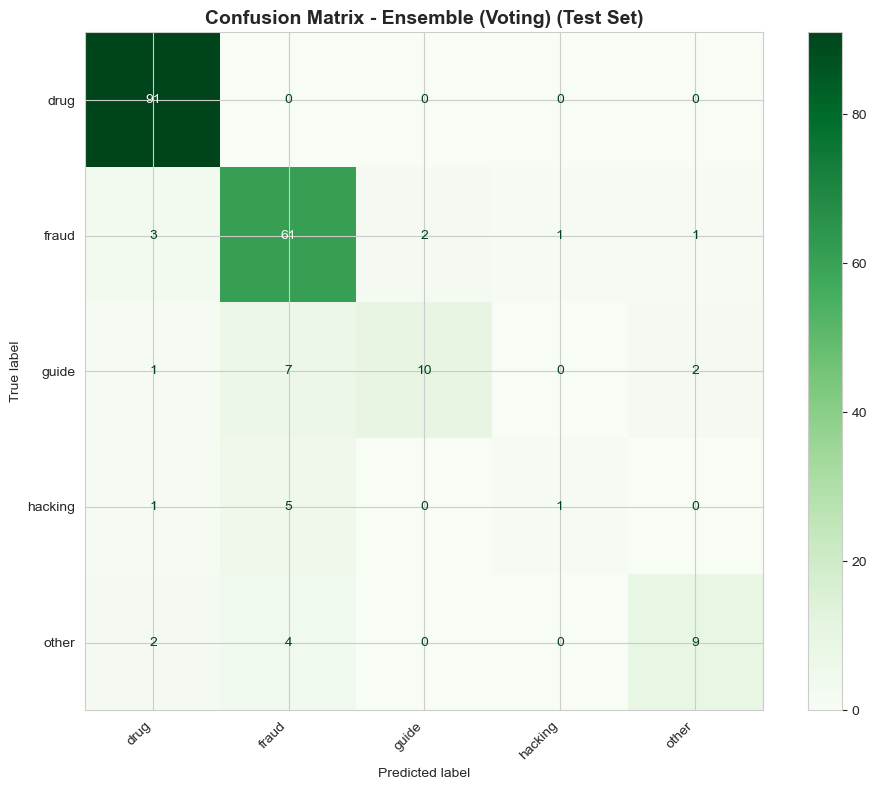

In [24]:
# Detailed test set evaluation for best model
y_pred_test_best = best_model.predict(X_test_tfidf)

print(f"\n{'='*80}")
print(f"CLASSIFICATION REPORT - {best_model_name} (Test Set)")
print(f"{'='*80}\n")
print(classification_report(y_test, y_pred_test_best, digits=4))

# Test set confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test_best)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
disp.plot(cmap='Greens', values_format='d', ax=plt.gca())
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 8. Save Best Model & Artifacts

In [25]:
# Save TF-IDF vectorizer
tfidf_path = MODELS_DIR / 'tfidf_vectorizer.pkl'
with open(tfidf_path, 'wb') as f:
    pickle.dump(tfidf, f)
print(f"💾 Saved TF-IDF vectorizer to: {tfidf_path.name}")

# Save best model
model_path = MODELS_DIR / f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"💾 Saved best model to: {model_path.name}")

# Save all models
all_models_path = MODELS_DIR / 'all_baseline_models.pkl'
with open(all_models_path, 'wb') as f:
    pickle.dump(trained_models, f)
print(f"💾 Saved all models to: {all_models_path.name}")

💾 Saved TF-IDF vectorizer to: tfidf_vectorizer.pkl
💾 Saved best model to: best_model_ensemble_(voting).pkl
💾 Saved all models to: all_baseline_models.pkl


In [26]:
# Save evaluation results
results_dict = {
    'validation_results': results_df.to_dict('records'),
    'test_results': test_results_df.to_dict('records'),
    'best_model': best_model_name,
    'dataset_info': {
        'total_samples': len(df),
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'num_features': X_train_tfidf.shape[1],
        'labels': labels
    },
    'tfidf_config': {
        'ngram_range': tfidf.ngram_range,
        'max_features': tfidf.max_features,
        'min_df': tfidf.min_df,
        'max_df': tfidf.max_df
    }
}

results_json_path = MODELS_DIR / 'baseline_results.json'
with open(results_json_path, 'w') as f:
    json.dump(results_dict, f, indent=2)
print(f"💾 Saved evaluation results to: {results_json_path.name}")

# Save results as CSV
results_csv_path = MODELS_DIR / 'baseline_results_summary.csv'
combined_results = pd.merge(
    results_df, 
    test_results_df, 
    on='Model', 
    suffixes=('_val', '_test')
)
combined_results.to_csv(results_csv_path, index=False)
print(f"💾 Saved results summary to: {results_csv_path.name}")

💾 Saved evaluation results to: baseline_results.json
💾 Saved results summary to: baseline_results_summary.csv


## 9. Summary & Insights

In [27]:
# Final summary
print("\n" + "="*80)
print("📊 BASELINE MODELS EXPERIMENT SUMMARY")
print("="*80)

print(f"\n📁 Dataset:")
print(f"   Total samples: {len(df):,}")
print(f"   Train/Val/Test: {len(X_train)}/{len(X_val)}/{len(X_test)}")
print(f"   Number of classes: {len(labels)}")
print(f"   Classes: {', '.join(labels)}")

print(f"\n🔧 Feature Extraction:")
print(f"   Method: TF-IDF (unigram + bigram)")
print(f"   Vocabulary size: {len(tfidf.vocabulary_):,} terms")
print(f"   Feature dimension: {X_train_tfidf.shape[1]:,}")

print(f"\n🤖 Models Trained: {len(trained_models)}")
for i, name in enumerate(trained_models.keys(), 1):
    print(f"   {i}. {name}")

print(f"\n🏆 Best Model: {best_model_name}")
best_test = test_results_df[test_results_df['Model'] == best_model_name].iloc[0]
print(f"   Validation F1: {results_df[results_df['Model'] == best_model_name].iloc[0]['F1-Score']:.4f}")
print(f"   Test F1:       {best_test['F1-Score']:.4f}")
print(f"   Test Accuracy: {best_test['Accuracy']:.4f}")

print(f"\n💾 Saved Artifacts:")
print(f"   - TF-IDF vectorizer")
print(f"   - Best model ({best_model_name})")
print(f"   - All baseline models")
print(f"   - Evaluation results (JSON + CSV)")

print(f"\n🎯 Next Steps:")
print(f"   1. Deep learning models (BERT, RoBERTa) in advanced_models.ipynb")
print(f"   2. Model explainability analysis in explainability.ipynb")
print(f"   3. Error analysis and model interpretation")
print(f"   4. Cross-lingual comparison (if applicable)")

print("\n" + "="*80)
print("✅ BASELINE MODELS TRAINING COMPLETE!")
print("="*80)


📊 BASELINE MODELS EXPERIMENT SUMMARY

📁 Dataset:
   Total samples: 1,334
   Train/Val/Test: 933/200/201
   Number of classes: 5
   Classes: drug, fraud, guide, hacking, other

🔧 Feature Extraction:
   Method: TF-IDF (unigram + bigram)
   Vocabulary size: 10,000 terms
   Feature dimension: 10,000

🤖 Models Trained: 6
   1. Logistic Regression
   2. Linear SVM
   3. Multinomial NB
   4. Random Forest
   5. Gradient Boosting
   6. Ensemble (Voting)

🏆 Best Model: Ensemble (Voting)
   Validation F1: 0.7667
   Test F1:       0.6636
   Test Accuracy: 0.8557

💾 Saved Artifacts:
   - TF-IDF vectorizer
   - Best model (Ensemble (Voting))
   - All baseline models
   - Evaluation results (JSON + CSV)

🎯 Next Steps:
   1. Deep learning models (BERT, RoBERTa) in advanced_models.ipynb
   2. Model explainability analysis in explainability.ipynb
   3. Error analysis and model interpretation
   4. Cross-lingual comparison (if applicable)

✅ BASELINE MODELS TRAINING COMPLETE!


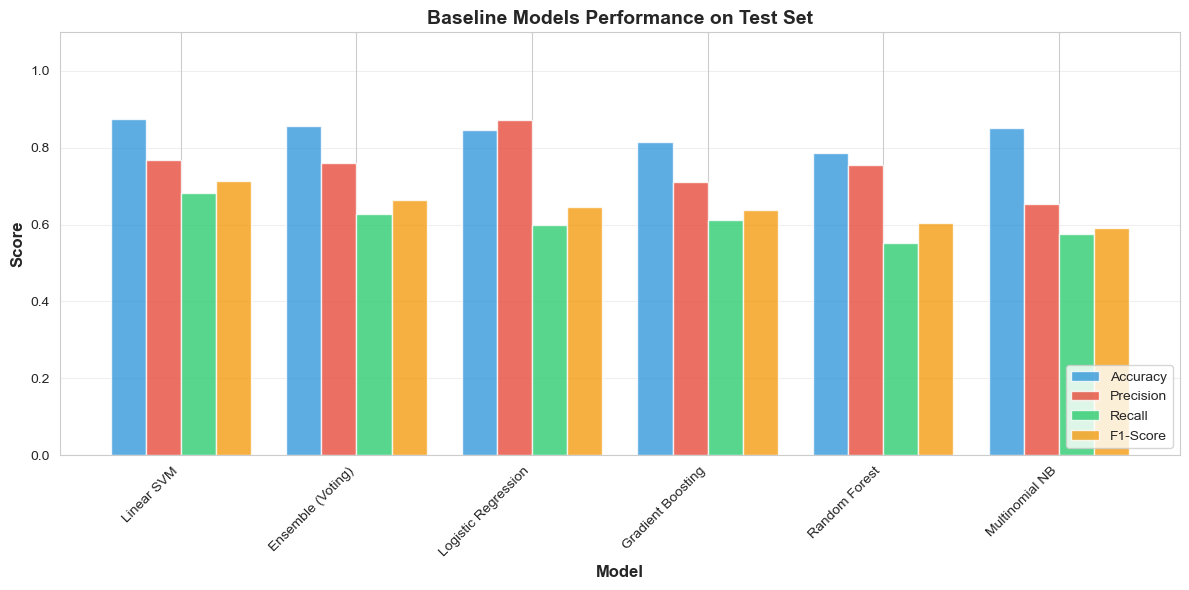


💾 Saved comparison chart to: baseline_comparison.png


In [28]:
# Performance comparison visualization
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(test_results_df))
width = 0.2

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_plot = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for i, (metric, color) in enumerate(zip(metrics_to_plot, colors_plot)):
    values = test_results_df[metric].values
    ax.bar(x + i*width, values, width, label=metric, color=color, alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Baseline Models Performance on Test Set', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(test_results_df['Model'], rotation=45, ha='right')
ax.legend(loc='lower right', fontsize=10)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(MODELS_DIR / 'baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Saved comparison chart to: baseline_comparison.png")